<a href="https://colab.research.google.com/github/andredss23/Projetos_Python/blob/main/Economic%20Complexity%20-%20Analysis%20about%20inequality%20and%20GDP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Industry Composition and Inequality: An Economic Complexity Perspective**

**Introduction**



*   Exploring the relationship between industrial evolution and income inequality in countries.


*   In our analysis, we used  employment data for 30 European countries to realize our measure of fitness. Eventually, we will study how the industrial evolution of countries relates to inequality, measured with the Gini Index, from 2010 to 2018.

**Literature Review**

*   Aghion et al. (2015) found a negative correlation between innovation and income inequality.

*   Studies could find that the association between economic complexity and inequality at the country level is negative, whereas this relationship is reversed at regional scales; in other words, more complex regions tend to be more unequal (Dominik Hartmann and Flávio L. Pinheiro, 2022).

*  Significant negative relationship between industrial employment and income inequality, in the sense that middle-earners have borne the largest burden in terms of inequality increases (Adrian Mehic, 2018).





**Research Question:**
"How does industrial composition relate with a country’s income inequality?"

# **Import Packages**

In [ ]:
# this piece of code loads the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pylab as plt

In [ ]:
# this code move to the shared drive contents
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Group6/data')
#os.chdir('drive/MyDrive/Group6/data')

Mounted at /content/drive


# **Analysis**

**Exploring Data Analysis**

**Structure of Employment (Eurostat’s Structural Business Service data) - 2018**

In [ ]:
df = pd.read_csv('employment/Employment matrix 2018.csv')

In [ ]:
df = df.set_index('Unnamed: 0').astype(int)

In [ ]:
df.shape

(30, 218)

In [ ]:
df.dtypes

In [ ]:
df.index.values

## **Summary**

*   30 Countries
*   218 industries
*   Eurostat’s Structural Business Service data
*   Gini Index
*   2010 - 2018





# **Mensuring ECI and Fitness**

**Revealed Comparative Advantage (RCA)**

In [ ]:
matrix = df.to_numpy()

In [ ]:
employment = np.sum(matrix,0)/np.sum(matrix)

In [ ]:
RCA = np.array([(row/sum(row))/employment for row in matrix])

In [ ]:
def rca(matrix):
    # global share
    employment = np.sum(matrix,0)/np.sum(matrix)
    return np.array([(row/sum(row))/employment for row in matrix])

**Binary matrix**

In [ ]:
threshold = 1
Mcp = np.array(np.where(RCA > threshold, 1, 0))
print(Mcp)

**Graphical representation of the matrices**

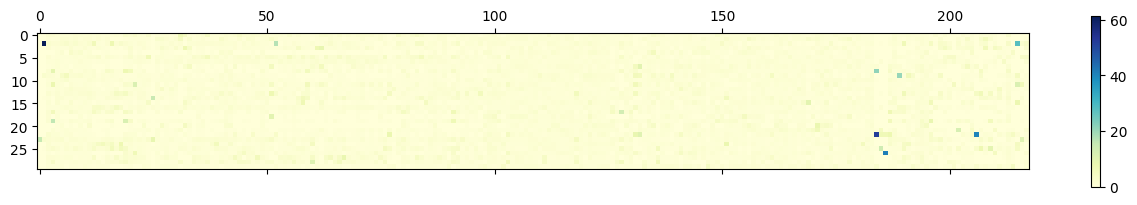

In [ ]:
colormap = 'YlGnBu'
plt.matshow(RCA, cmap=colormap)
plt.colorbar()
plt.show()

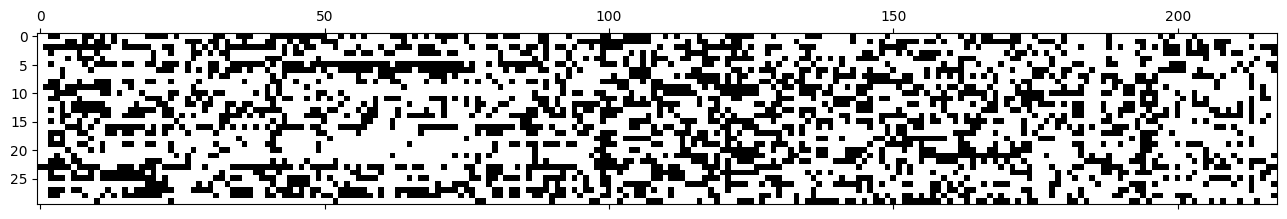

In [ ]:
# the binary RCA representation
colormap = 'binary'
plt.matshow(Mcp, cmap = colormap)
plt.show()

In [ ]:
# The ubiquity of an Activity measures the number of Actors that are competitive in that Activity
ubiquity = np.sum(Mcp, axis = 0)

# the order of the products with respect to their ubiquity
order_products = np.argsort(ubiquity)[::-1]

In [ ]:
# The diversification of an Actor measures how large is the basket of the Activities in which the Actor is competitive
diversification = np.sum(Mcp, axis = 1)

# the order of the countries with respect to their diversification
order_countries = np.argsort(diversification)[::-1]

**Define Economic Complexity Index ECI & Fitness**

In [ ]:
# the routine computes and returns ECI and PCI
def Method_of_Reflections(Mcp, maximal_iterations=10):

    # the matrices used to project on the country and product spaces separately
    ubiquity = np.sum(Mcp, axis = 0)
    diversification = np.sum(Mcp, axis = 1)

    # initial condition (here I consider the normalized degrees of each node)
    kc = diversification / diversification.sum()
    kp = ubiquity / ubiquity.sum()

    # the transpose
    Mpc = np.transpose(Mcp)

    # loop
    kc_old = kc
    kp_old = kp
    for iteration in range(maximal_iterations):

        kc = Mcp.dot(kp_old)/diversification
        kp = Mpc.dot(kc_old)/ubiquity

        kc_old = kc
        kp_old = kp

    return kc/kc.mean(), kp/kp.mean()

In [ ]:
# this routine computes the eigenvalue ECI and PCI
def ECI_PCI_eigenvalue(Mcp):

    # the matrices used to project on the country and product spaces separately
    vec = np.sum(Mcp,1).astype(float)
    np.divide(np.ones_like(vec), vec, out=vec, where=vec != 0)
    Pcp = np.transpose(np.transpose(Mcp)*vec)

    vec = np.sum(Mcp,0).astype(float)
    np.divide(np.ones_like(vec), vec, out=vec, where=vec != 0)
    Ppc = np.transpose(Mcp*vec)

    # the projections
    Mcc = np.matmul(Pcp,Ppc)
    Mpp = np.matmul(Ppc,Pcp)

    # eci eigenvector
    eigvalues, eigvectors = np.linalg.eig(Mcc)
    eci = np.real(eigvectors[:, eigvalues.argsort()[-2]])

    # the score of the eigenvector
    eci = (eci - eci.mean())/eci.std()

    if np.corrcoef(eci,np.sum(Mcp,1))[0,1] < 0:
        eci *= -1

    eigvalues, eigvectors = np.linalg.eig(Mpp)
    pci = np.real(eigvectors[:, eigvalues.argsort()[-2]])

    # the score of the eigenvector
    pci = (pci - pci.mean())/pci.std()


    if np.corrcoef(pci,np.sum(Mcp,0))[0,1] < 0:
        pci *= -1

    return eci, pci

In [ ]:
# the iterative FC routine returning fitness and complexity
def fitness_complexity_algorithm(Mcp, maximal_iterations = 100):

    # initial condition (here I consider the degrees of each node)
    fitness = np.array(np.sum(Mcp, axis = 1)/np.sum(Mcp))

    #complexity = np.nan_to_num(1./np.array(np.sum(Mcp, axis = 0)))
    complexity = np.array(np.sum(Mcp, axis = 0)).astype(np.float64)
    one_fit = np.ones_like(fitness)
    one_com = np.ones_like(complexity)
    np.divide(one_com, complexity, out=complexity, where=complexity != 0)

    complexity /= complexity.sum()
    Mpc = np.transpose(Mcp)
    inverse_fitness = np.zeros_like(fitness)

    # loop over the iterations
    for iteration in range(maximal_iterations):

        # compute the inverse fitness
        np.divide(one_fit, fitness, out=inverse_fitness, where=fitness != 0)

        # update the fitness
        fitness = Mcp.dot(complexity)
        fitness /= fitness.sum()

        # update the complexity
        complexity = Mpc.dot(inverse_fitness)
        np.divide(one_com, complexity, out=complexity, where=complexity != 0)
        complexity /= complexity.sum()

    return fitness/fitness.mean(),complexity/complexity.mean()

# **Mensuring ECI,  Fitness and Gini Index**

In [ ]:
emp = {}
for year in range(2010, 2019):
    emp[year] = pd.read_csv('employment/Employment matrix {}.csv'.format(year), index_col=0)

In [ ]:
binary_rca = {}
for year in range(2010,2019):
    mat = emp[year].copy()
    rcamat = ((mat/mat.sum(0)).transpose()/mat.sum(1)*mat.sum().sum()).transpose().fillna(0)
    binary_rca[year] = (rcamat>=1).astype(int)

In [ ]:
# create empty variables storing the diversification and the ubiquity, using the pandas DataFrames
diversification = pd.DataFrame(columns=range(2010,2019), index=binary_rca[2010].index)
ubiquity = pd.DataFrame(columns=range(2010,2019), index=binary_rca[2010].columns)

# loop over the years
for year in range(2010,2019):
    mat = binary_rca[year]
    diversification[year] = pd.Series(mat.sum(1), index=mat.index)
    ubiquity[year] = pd.Series(mat.sum(0), index=mat.columns)

In [ ]:
#diversification (2010-2018)
diversification

In [ ]:
#ubiquity (2010-2018)
ubiquity

In [ ]:
# loop over the time series
fitness = pd.DataFrame(columns=range(2010,2019), index=binary_rca[2010].index)
complexity = pd.DataFrame(columns=range(2010,2019), index=binary_rca[2010].columns)

for year in range(2010,2019):
    mat = binary_rca[year].copy()

    fit, com = fitness_complexity_algorithm(mat.to_numpy(), maximal_iterations = 200)

    fitness[year] = pd.Series(fit, index=mat.index)
    complexity[year] = pd.Series(com, index=mat.columns)

In [ ]:
#fitness (2010-2018)
fitness

In [ ]:
# complexity (2010-2018)
complexity

In [ ]:
# loop over the time series
eci = pd.DataFrame(columns=range(2010,2019), index=binary_rca[2010].index)
pci = pd.DataFrame(columns=range(2010,2019), index=binary_rca[2010].columns)

for year in range(2010,2019):
    mat = binary_rca[year].copy()

    eci_score, pci_score = ECI_PCI_eigenvalue(mat.to_numpy())

    eci[year] = pd.Series(eci_score, index=mat.index)
    pci[year] = pd.Series(pci_score, index=mat.columns)

In [ ]:
# ECI (2010-2018)
eci

In [ ]:
# PCI (2010-2018)
pci

**GINI INDEX**

In [ ]:
gini = pd.read_csv('economic/gini.csv')

In [ ]:
df1 = pd.read_csv('employment/Employment matrix 2018.csv')

In [ ]:
df1.head()

In [ ]:
country_codes = df1['Unnamed: 0'].unique().tolist()
gini = gini[gini['Country Code'].isin(country_codes)]
gini.head()

In [ ]:
years_to_drop1 = [str(year) for year in range(1990, 2010)]

# Drop the specified columns
gini = gini.drop(years_to_drop1, axis=1)

years_to_drop2 = [col for col in gini.columns if col.isnumeric() and int(col) > 2018]

# Drop the specified columns
gini = gini.drop(years_to_drop2, axis=1)

In [ ]:
gini

In [ ]:
fit = pd.DataFrame(fitness)
fit = fit.reset_index()
fit = fit.rename(columns={'index': 'Country Code'})
fit = fit.set_index('Country Code')

In [ ]:
eci1 = pd.DataFrame(eci)
eci1 = eci1.reset_index()
eci1 = eci1.rename(columns={'index': 'Country Code'})
eci1 = eci1.set_index('Country Code')

In [ ]:
gin = pd.DataFrame(gini)
gin = gin.set_index('Country Code')

In [ ]:
index_valuesG = gin.index.values
print(index_valuesG)

In [ ]:
gin_sorted = gin.sort_index()

# Retrieve the values from the index column in alphabetical order
index_valuesG = gin_sorted.index.tolist()
print(index_valuesG)

In [ ]:
fit_sorted = fit.sort_index()

# Retrieve the values from the index column in alphabetical order
index_valuesF = fit_sorted.index.tolist()
print(index_valuesF)

In [ ]:
# Checking shape is the same for Fitness and Gini dataframe
fit.shape==gin.shape

In [ ]:
# Checking shape is the same for ECI and Gini dataframe
eci1.shape==gin.shape

In [ ]:
subset_countries = ['AUT', 'BEL', 'BGR', 'CHE', 'CYP', 'CZE', 'DEU', 'DNK', 'ESP', 'EST', 'FIN', 'FRA', 'GBR', 'GRC', 'HRV', 'HUN', 'IRL', 'ITA', 'LTU', 'LUX', 'LVA', 'MLT', 'NLD', 'NOR', 'POL', 'PRT', 'ROU', 'SVK', 'SVN', 'SWE']

In [ ]:
gin

,2010,2011,2012,2013,2014,2015,2016,2017,2018
Country Code,,,,,,,,,
AUT,30.3,30.8,30.5,30.8,30.5,30.5,30.8,29.7,30.8
BEL,28.4,28.1,27.5,27.7,28.1,27.7,27.6,27.4,27.2
BGR,35.7,34.3,36.0,36.6,37.4,38.6,40.6,40.4,41.3
CHE,32.6,31.7,31.6,32.5,32.5,32.3,33.0,32.7,33.1
CYP,31.5,32.6,34.3,37.0,35.6,34.0,32.9,31.4,32.7
CZE,26.6,26.4,26.1,26.5,25.9,25.9,25.4,24.9,25.0
DEU,30.3,30.7,31.1,31.5,30.9,31.4,31.4,31.9,31.8
DNK,27.2,27.3,27.8,28.5,28.4,28.2,28.2,28.7,28.2
ESP,35.2,35.7,35.4,36.2,36.1,36.2,35.8,34.7,34.7


In [ ]:
fit

,2010,2011,2012,2013,2014,2015,2016,2017,2018
Country Code,,,,,,,,,
AUT,1.140003,1.125187,1.112746,1.110240,1.128064,1.100008,1.129313,1.150368,1.049813
BEL,1.030129,1.056732,0.994533,0.994295,0.929835,0.912522,0.890125,0.894076,0.956423
BGR,1.173337,1.116826,1.174182,1.179990,1.248447,1.250359,1.365730,1.384687,1.373246
CHE,1.160784,1.146863,1.128490,1.008134,1.089839,0.970140,0.951227,0.999724,0.906455
CYP,0.551006,0.574469,0.566194,0.524524,0.547479,0.556883,0.540555,0.556980,0.578426
CZE,1.491076,1.415881,1.409294,1.446517,1.446121,1.444825,1.448153,1.483203,1.488844
DEU,1.483771,1.406683,1.454770,1.634716,1.461469,1.420626,1.575358,1.679422,1.634508
DNK,0.846965,1.005708,0.982544,0.933765,0.975788,0.993168,0.824908,0.821887,0.857613
EST,0.821217,0.843635,0.828488,0.822019,0.768744,0.793271,0.865841,0.824783,0.850132


In [ ]:
eci1

,2010,2011,2012,2013,2014,2015,2016,2017,2018
Country Code,,,,,,,,,
AUT,0.320679,0.283258,0.266156,0.254154,0.342273,0.240563,0.496402,0.518843,0.371708
BEL,-0.398923,-0.430166,-0.440291,-0.488382,-0.612340,-0.648938,-0.595405,-0.524048,-0.540783
BGR,1.210271,1.151576,1.120872,1.166354,1.067708,1.189372,1.155778,1.064854,1.093133
CHE,-0.410560,-0.446799,-0.363462,-0.421298,-0.484034,-0.529797,-0.425879,-0.433176,-0.385131
CYP,-1.213073,-1.168915,-1.011208,-1.005026,-1.193345,-0.938042,-0.967276,-1.068319,-1.005171
CZE,1.455869,1.508756,1.521023,1.565479,1.583115,1.486357,1.517324,1.632753,1.524680
DEU,0.170126,0.143091,0.138397,0.249471,0.393735,0.097561,0.320765,0.540520,0.293176
DNK,-1.014715,-0.719558,-0.670041,-0.668883,-0.632927,-0.744460,-1.158469,-1.027492,-1.061155
EST,0.349762,0.560780,0.572800,0.406829,0.612093,0.564904,0.334561,0.354444,0.400414


# **Results**

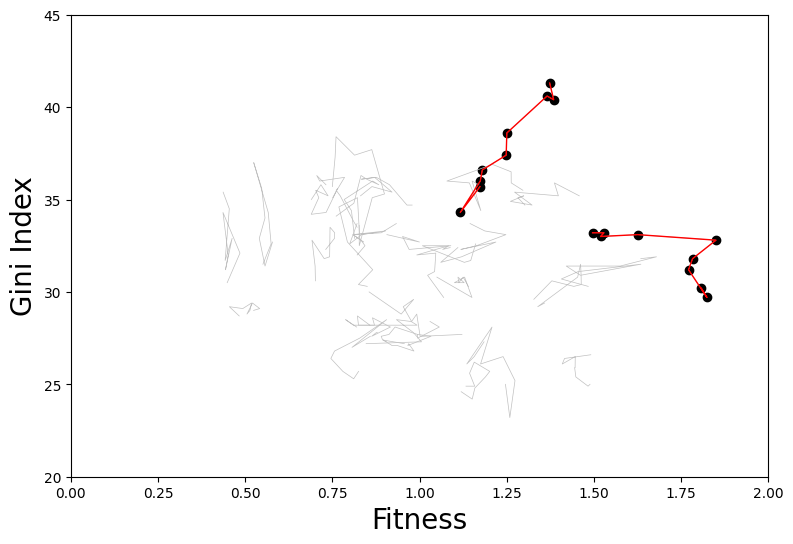

In [ ]:
set1 = fit
set2 = gin
list_idx = subset_countries

fig, ax = plt.subplots(figsize=(9,6))
ax.set(xscale='linear',yscale='linear')
ax.set_xlim(0,2)
ax.set_ylim(20,45)

plt.xlabel('Fitness', size=20, x=0.5)
plt.ylabel('Gini Index', size=20, y=0.5)

#ax.scatter(set1,set2)
for idx in list_idx:
    ax.plot(set1.loc[idx],set2.loc[idx], color='silver', lw=0.5)

for idx in ['BGR','POL']:
    ax.plot(set1.loc[idx],set2.loc[idx], color='red', lw=1)
    ax.scatter(set1.loc[idx],set2.loc[idx], color='black')


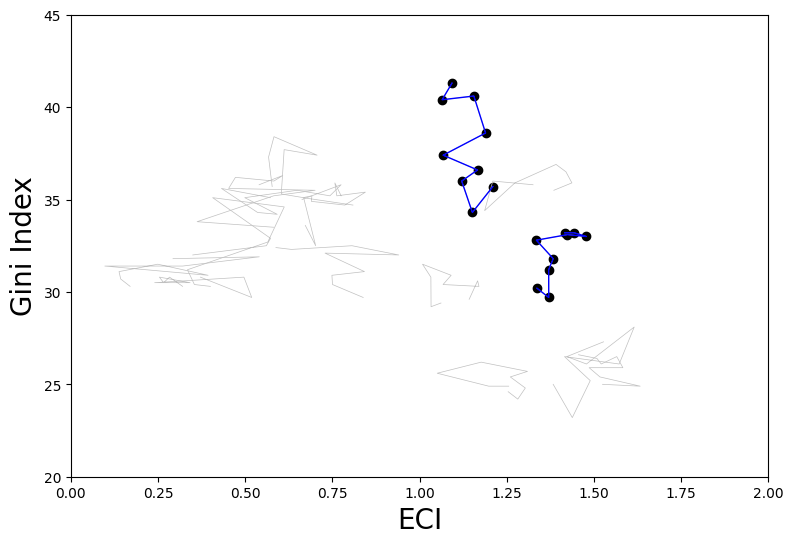

In [ ]:
set1 = eci1
set2 = gin
list_idx = subset_countries

fig, ax = plt.subplots(figsize=(9,6))
ax.set(xscale='linear',yscale='linear')
ax.set_xlim(0,2)
ax.set_ylim(20,45)

plt.xlabel('ECI', size=20, x=0.5)
plt.ylabel('Gini Index', size=20, y=0.5)

#ax.scatter(set1,set2)
for idx in list_idx:
    ax.plot(set1.loc[idx],set2.loc[idx], color='silver', lw=0.5)

for idx in ['BGR','POL']:
    ax.plot(set1.loc[idx],set2.loc[idx], color='blue', lw=1)
    ax.scatter(set1.loc[idx],set2.loc[idx], color='black')

# **TRENDS**

**FITNESS**

In [ ]:
fit1 = fit.reset_index()

In [ ]:
fit1 = fit1.rename(columns={'Country Code': 'Country'})


In [ ]:
fit1 = fit1.set_index('Country')


In [ ]:
fit1.head()

,2010,2011,2012,2013,2014,2015,2016,2017,2018
Country,,,,,,,,,
AUT,1.140003,1.125187,1.112746,1.110240,1.128064,1.100008,1.129313,1.150368,1.049813
BEL,1.030129,1.056732,0.994533,0.994295,0.929835,0.912522,0.890125,0.894076,0.956423
BGR,1.173337,1.116826,1.174182,1.179990,1.248447,1.250359,1.365730,1.384687,1.373246
CHE,1.160784,1.146863,1.128490,1.008134,1.089839,0.970140,0.951227,0.999724,0.906455
CYP,0.551006,0.574469,0.566194,0.524524,0.547479,0.556883,0.540555,0.556980,0.578426


In [ ]:
Fit_T = fit1.T


In [ ]:
Fit_T.head()

Country,AUT,BEL,BGR,CHE,CYP,CZE,DEU,DNK,EST,GRC,...,MLT,NLD,NOR,POL,PRT,ROU,SWE,SVN,SVK,GBR
2010,1.140003,1.030129,1.173337,1.160784,0.551006,1.491076,1.483771,0.846965,0.821217,0.760973,...,0.524184,0.879100,0.825307,1.496130,0.731691,1.296395,1.121673,1.133216,1.184981,0.933504
2011,1.125187,1.056732,1.116826,1.146863,0.574469,1.415881,1.406683,1.005708,0.843635,0.811726,...,0.541637,0.876308,0.811141,1.528720,0.705217,1.262929,1.008542,1.158241,1.156764,0.890249
2012,1.112746,0.994533,1.174182,1.128490,0.566194,1.409294,1.454770,0.982544,0.828488,0.832116,...,0.521060,0.862859,0.780148,1.519091,0.713789,1.262647,1.001668,1.143497,1.135467,0.809429
2013,1.110240,0.994295,1.179990,1.008134,0.524524,1.446517,1.634716,0.933765,0.822019,0.848528,...,0.505106,0.916471,0.745737,1.625512,0.785083,1.209172,0.992021,1.156907,1.207863,0.839119
2014,1.128064,0.929835,1.248447,1.089839,0.547479,1.446121,1.461469,0.975788,0.768744,0.883266,...,0.513751,0.864990,0.756272,1.849995,0.765930,1.078452,0.977237,1.201324,1.175027,0.809363


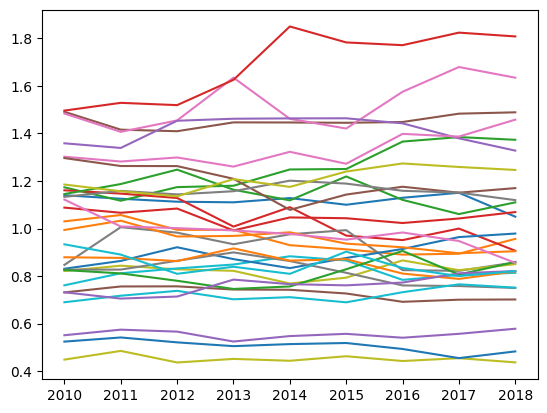

In [ ]:
for index in Fit_T.columns:
    data = Fit_T[index]
    plt.plot(data, label='country')

**GINI**

In [ ]:
gini1 = gin.reset_index()


In [ ]:
gini1 = gini1.rename(columns={'Country Code': 'Country'})


In [ ]:
gini1 = gini1.set_index('Country')


In [ ]:
gini1.head()

,2010,2011,2012,2013,2014,2015,2016,2017,2018
Country,,,,,,,,,
AUT,30.3,30.8,30.5,30.8,30.5,30.5,30.8,29.7,30.8
BEL,28.4,28.1,27.5,27.7,28.1,27.7,27.6,27.4,27.2
BGR,35.7,34.3,36.0,36.6,37.4,38.6,40.6,40.4,41.3
CHE,32.6,31.7,31.6,32.5,32.5,32.3,33.0,32.7,33.1
CYP,31.5,32.6,34.3,37.0,35.6,34.0,32.9,31.4,32.7


In [ ]:
gin_T = gini1.T


In [ ]:
gin_T.head()

Country,AUT,BEL,BGR,CHE,CYP,CZE,DEU,DNK,ESP,EST,...,LVA,MLT,NLD,NOR,POL,PRT,ROU,SVK,SVN,SWE
2010,30.3,28.4,35.7,32.6,31.5,26.6,30.3,27.2,35.2,32.0,...,35.0,29.0,27.8,25.7,33.2,35.8,35.5,27.3,24.9,27.7
2011,30.8,28.1,34.3,31.7,32.6,26.4,30.7,27.3,35.7,32.5,...,35.8,29.1,27.8,25.3,33.2,36.3,35.9,26.5,24.9,27.6
2012,30.5,27.5,36.0,31.6,34.3,26.1,31.1,27.8,35.4,32.9,...,35.2,29.4,27.6,25.7,33.0,36.0,36.5,26.1,25.6,27.6
2013,30.8,27.7,36.6,32.5,37.0,26.5,31.5,28.5,36.2,35.1,...,35.5,28.8,28.1,26.4,33.1,36.2,36.9,28.1,26.2,28.8
2014,30.5,28.1,37.4,32.5,35.6,25.9,30.9,28.4,36.1,34.6,...,35.1,29.0,28.6,26.8,32.8,35.6,36.0,26.1,25.7,28.4


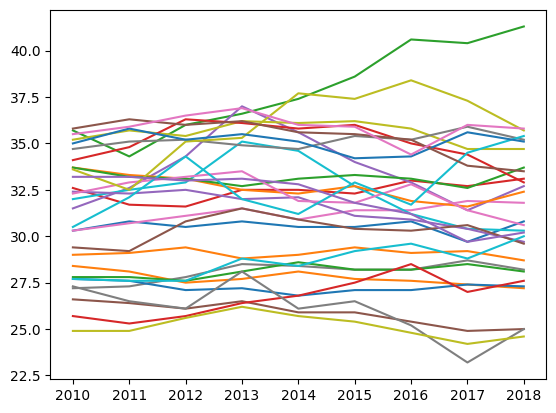

In [ ]:
for index in gin_T.columns:
    data = gin_T[index]
    plt.plot(data, label='country')

**CORRELATION ANALYSIS**

In [ ]:
print(gini1)

         2010  2011  2012  2013  2014  2015  2016  2017  2018
Country                                                      
AUT      30.3  30.8  30.5  30.8  30.5  30.5  30.8  29.7  30.8
BEL      28.4  28.1  27.5  27.7  28.1  27.7  27.6  27.4  27.2
BGR      35.7  34.3  36.0  36.6  37.4  38.6  40.6  40.4  41.3
CHE      32.6  31.7  31.6  32.5  32.5  32.3  33.0  32.7  33.1
CYP      31.5  32.6  34.3  37.0  35.6  34.0  32.9  31.4  32.7
CZE      26.6  26.4  26.1  26.5  25.9  25.9  25.4  24.9  25.0
DEU      30.3  30.7  31.1  31.5  30.9  31.4  31.4  31.9  31.8
DNK      27.2  27.3  27.8  28.5  28.4  28.2  28.2  28.7  28.2
ESP      35.2  35.7  35.4  36.2  36.1  36.2  35.8  34.7  34.7
EST      32.0  32.5  32.9  35.1  34.6  32.7  31.2  30.4  30.3
FIN      27.7  27.6  27.1  27.2  26.8  27.1  27.1  27.4  27.3
FRA      33.7  33.3  33.1  32.5  32.3  32.7  31.9  31.6  32.4
GBR      33.7  33.2  33.1  32.7  33.1  33.3  33.1  32.6  33.7
GRC      34.1  34.8  36.3  36.1  35.8  36.0  35.0  34.4  32.9
HRV     

In [ ]:
print(fit1)

In [ ]:
#2010-2010

G2010 = gini1[gini1.columns[0]]
F2010 = fit1[fit1.columns[0]]

Corr2010 = pd.concat([G2010, F2010], axis=1)

Corr2010.rename(columns={Corr2010.columns[0]: 'GINI'}, inplace=True)
Corr2010.rename(columns={Corr2010.columns[1]: 'FITNESS'}, inplace=True)

correlation_matrix2010 = Corr2010[['GINI', 'FITNESS']].corr()
C2010 = correlation_matrix2010.loc['GINI', 'FITNESS']
print(C2010)

-0.08156709861645679


In [ ]:
#2010-2011

G2011 = gini1[gini1.columns[1]]
F2010 = fit1[fit1.columns[0]]

Corr20101 = pd.concat([G2011, F2010], axis=1)

Corr20101.rename(columns={Corr20101.columns[0]: 'GINI'}, inplace=True)
Corr20101.rename(columns={Corr20101.columns[1]: 'FITNESS'}, inplace=True)

correlation_matrix20101 = Corr20101[['GINI', 'FITNESS']].corr()
C2011 = correlation_matrix20101.loc['GINI', 'FITNESS']
print(C2011)

-0.15959622038278048


In [ ]:
#2010-2012

G2012 = gini1[gini1.columns[2]]
F2010 = fit1[fit1.columns[0]]

Corr20102 = pd.concat([G2012, F2010], axis=1)

Corr20102.rename(columns={Corr20102.columns[0]: 'GINI'}, inplace=True)
Corr20102.rename(columns={Corr20102.columns[1]: 'FITNESS'}, inplace=True)

correlation_matrix20102 = Corr20102[['GINI', 'FITNESS']].corr()
C2012 = correlation_matrix20102.loc['GINI', 'FITNESS']
print(C2012)

-0.2133753887719275


In [ ]:
G2013 = gini1[gini1.columns[3]]
F2010 = fit1[fit1.columns[0]]

Corr20103 = pd.concat([G2013, F2010], axis=1)

Corr20103.rename(columns={Corr20103.columns[0]: 'GINI'}, inplace=True)
Corr20103.rename(columns={Corr20103.columns[1]: 'FITNESS'}, inplace=True)

correlation_matrix20103 = Corr20103[['GINI', 'FITNESS']].corr()
C2013 = correlation_matrix20103.loc['GINI', 'FITNESS']
print(C2013)

-0.1904309752573993


In [ ]:
G2014 = gini1[gini1.columns[4]]
F2010 = fit1[fit1.columns[0]]

Corr20104 = pd.concat([G2014, F2010], axis=1)

Corr20104.rename(columns={Corr20104.columns[0]: 'GINI'}, inplace=True)
Corr20104.rename(columns={Corr20104.columns[1]: 'FITNESS'}, inplace=True)

correlation_matrix20104 = Corr20104[['GINI', 'FITNESS']].corr()
C2014 = correlation_matrix20104.loc['GINI', 'FITNESS']
print(C2014)

-0.1970172702022754


In [ ]:
G2015 = gini1[gini1.columns[5]]
F2010 = fit1[fit1.columns[0]]

Corr20105 = pd.concat([G2015, F2010], axis=1)

Corr20105.rename(columns={Corr20105.columns[0]: 'GINI'}, inplace=True)
Corr20105.rename(columns={Corr20105.columns[1]: 'FITNESS'}, inplace=True)

correlation_matrix20105 = Corr20105[['GINI', 'FITNESS']].corr()
C2015 = correlation_matrix20105.loc['GINI', 'FITNESS']
print(C2015)

-0.19363028788135217


In [ ]:
G2016 = gini1[gini1.columns[6]]
F2010 = fit1[fit1.columns[0]]

Corr20106 = pd.concat([G2016, F2010], axis=1)

Corr20106.rename(columns={Corr20106.columns[0]: 'GINI'}, inplace=True)
Corr20106.rename(columns={Corr20106.columns[1]: 'FITNESS'}, inplace=True)

correlation_matrix20106 = Corr20106[['GINI', 'FITNESS']].corr()
C2016 = correlation_matrix20106.loc['GINI', 'FITNESS']
print(C2016)

-0.17474197964804436


In [ ]:
G2017 = gini1[gini1.columns[7]]
F2010 = fit1[fit1.columns[0]]

Corr20107 = pd.concat([G2017, F2010], axis=1)

Corr20107.rename(columns={Corr20107.columns[0]: 'GINI'}, inplace=True)
Corr20107.rename(columns={Corr20107.columns[1]: 'FITNESS'}, inplace=True)

correlation_matrix20107 = Corr20107[['GINI', 'FITNESS']].corr()
C2017 = correlation_matrix20107.loc['GINI', 'FITNESS']
print(C2017)

-0.18226926352826178


In [ ]:
G2018 = gini1[gini1.columns[8]]
F2010 = fit1[fit1.columns[0]]

Corr20108 = pd.concat([G2018, F2010], axis=1)

Corr20108.rename(columns={Corr20108.columns[0]: 'GINI'}, inplace=True)
Corr20108.rename(columns={Corr20108.columns[1]: 'FITNESS'}, inplace=True)

correlation_matrix20108 = Corr20108[['GINI', 'FITNESS']].corr()
C2018 = correlation_matrix20108.loc['GINI', 'FITNESS']
print(C2018)

-0.16510955626583954


In [ ]:

Corr = {'Year': ['2010', '2011', '2012','2013', '2014', '2015','2016', '2017', '2018'],
        'Correlation': [C2010, C2011, C2012, C2013, C2014, C2015, C2016, C2017, C2018],}

Corr = pd.DataFrame(Corr)
print(Corr)

   Year  Correlation
0  2010    -0.081567
1  2011    -0.159596
2  2012    -0.213375
3  2013    -0.190431
4  2014    -0.197017
5  2015    -0.193630
6  2016    -0.174742
7  2017    -0.182269
8  2018    -0.165110


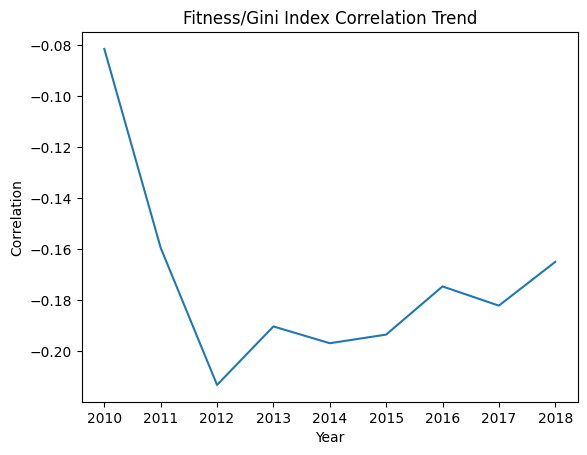

In [ ]:
import matplotlib.pyplot as plt

x_axis = ['2010', '2011', '2012','2013', '2014', '2015','2016', '2017', '2018']
y_axis = [C2010, C2011, C2012, C2013, C2014, C2015, C2016, C2017, C2018]

plt.plot(x_axis, y_axis)
plt.title('Fitness/Gini Index Correlation Trend')
plt.xlabel('Year')
plt.ylabel('Correlation')
plt.show()